In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [34]:
class SHE():
    def __init__(self, N = 100, g  =1 , u = 0.25 , T = 0.5, CFL = 0.5 , flux = 'LF'):
        self.N = N
        self.g = g
        self.dx = 2/(N)
        self.k = None
        self.u = u
        self.bc = None
        h = np.zeros(N+1)
        m = np.zeros(N+1)
        self.q = np.array([h,m])
        self.x = np.linspace(0, 2, N+1)
        self.CFL = 0.5
        self.T = T
        self.t = 0
        self.h0 = None
        self.use_source = True
        if flux == 'LF':
          self.flux = self.F
        else:
          self.flux = self.FLW


    def update_k(self):
        u = self.q[1] / self.q[0]
        self.k = self.CFL * self.dx / (np.max(np.abs(u) + np.sqrt(self.g*self.q[0])))

    def update_N(self, N_new):
        self.N = N_new
        self.dx = 2/N_new
        h = np.zeros(N_new+1)
        m = np.zeros(N_new+1)
        self.q = np.array([h,m])
        self.x = np.linspace(0, 2, N_new+1)

    def IV(self , h:callable , m:callable):
        self.h0 = h
        self.q[0] = h(self.x)
        self.q[1] = m(self.x)

    def f(self , u):
        #print(f"u_1 is {u[0],u[1]}")
        return np.array([u[1], ((u[1]**2)/u[0]) + 0.5*self.g*(u[0]**2)])

    def Jf(self, u):
        Jf = np.ndarray((2,2))
        Jf[0,0] = 0
        Jf[0,1] = 1
        Jf[1,0] = (-1)*(u[1]**2)/(u[0]**2) + self.g*u[0]
        Jf[1,1] = 2*(u[1]/u[0])
        return Jf

    def F(self , u,v):
        #print(u.shape)
        #print(self.f(u) + self.f(v))
        #print(np.array(0.5 * (self.f(u) + self.f(v)) - 0.5*(self.k / self.dx)*(v - u)))
        return np.array(0.5 * (self.f(u) + self.f(v)) - 0.5*(self.dx / self.k)*(v - u))

    def FLW(self,u,v):
        '''
            Question for Jun: in LW method we have to evaluate f'((u+v)/2) but here f:R^2->R^2 so f' = Jf.
            Jf((u+v)/2) (f(v)-f(u)) \in R^2 so should be fine, what do you think?
        '''
        return np.array(0.5*(self.f(u)+self.f(v)) - 0.5*(self.k/self.dx)*(self.Jf(0.5*(u+v))@(self.f(v)-self.f(u))))

    def S(self, x_val):
        s1 = np.pi/2 * (self.u-1) * np.cos(np.pi*(x_val-self.t))
        s2 = np.pi/2 * np.cos(np.pi*(x_val-self.t)) * (-self.u+(self.u**2)+self.g*self.h0(x_val-self.t))
        #print(s1,s2)
        return np.array([s1, s2])

    def set_BC(self , bc):
        self.bc = bc

    def set_Source(self , us):
        # boolean
        self.use_source = us

    def Solve(self):
        self.t=0

        if self.bc=="P":
            while self.t < self.T:
                #print(self.t)

                #print(f"Hi, from time {self.t} with {self.q[0,0]}")
                self.update_k()

                if self.t + self.k > self.T:
                    self.k = self.T - self.t


                q_old = self.q.copy()

                for j in range(self.N+1):

                    flux_term = self.F(q_old[:,j] , q_old[:,(j+1) % self.N]) - self.F(q_old[:, (j-1) % self.N] , q_old[:,j])

                    if(self.use_source):
                        self.q[:,j] = q_old[:,j] - (self.k/self.dx)*flux_term + self.k * self.S(self.dx * j)
                    else:
                        self.q[:,j] = q_old[:,j] - (self.k/self.dx)*flux_term
                    #break


                self.t += self.k
                #break

        elif self.bc=="O":
            while self.t < self.T:
                self.update_k()

                if self.t + self.k > self.T:
                    self.k = self.T - self.t

                self.t += self.k
                q_old = self.q.copy()
                for j in range(1 , self.N):
                    flux_term = self.flux(q_old[:,j] , q_old[:,(j+1)]) - self.flux(q_old[:, (j-1)] , q_old[:,j])

                    if(self.use_source):
                        self.q[:,j] = q_old[:,j] - (self.k/self.dx)*flux_term + self.k * self.S(self.dx * j)
                    else:
                        self.q[:,j] = q_old[:,j] - (self.k/self.dx)*flux_term


                self.q[:,0] = self.q[:,1]
                self.q[:,self.N] = self.q[:,self.N-1]
        else:
          print("No BC selected")
          exit()

    '''
        Question for Jun:
        There is something wrong that I don't see, the same bc on the other method seems to work fine.
        Here we have the same problem of a negative sqrt, can you take a look?
    '''
    def SolveLW(self):
        self.t = 0

        while self.t < self.T:
            self.update_k()

            if self.t + self.k > self.T:
                self.k = self.T - self.t
            self.t += self.k

            q_old = self.q.copy()

            for j in range(1, self.N):
                flux_term = self.FLW(q_old[:,j] , q_old[:,(j+1) % self.N]) - self.FLW(q_old[:, (j-1) % self.N] , q_old[:,j])
                self.q[:,j] = q_old[:,j] - (self.k/self.dx)*flux_term

            self.q[:,0] = self.q[:,1]
            self.q[:,self.N] = self.q[:,self.N-1]


In [35]:
### Implementing all the initial values:

#A
def h0_A(x):
    return 1 + 0.5*np.sin(np.pi * x)

def m0_A(x , u = 0.25):
    return u * h0_A(x)

#B
def h0_B(x):
    return 1 - 0.1*np.sin(np.pi * x)

def m0_B(x , u = 0.25):
    return 0


#C
def h0_C(x):
    return 1 - 0.2*np.sin(2 * np.pi * x)

def m0_C(x , u = 0.25):
    return 0.5

#D
def h0_D(x):
    return 1

def m0_D(x , u = 0.25):
    return np.piecewise(x, [x < 1, x>=1], [lambda x: -0.5, lambda x: 0])

In [17]:
def Convergence_analysis(final_time , N_initial , iterations , bc , h0, m0, h_ref, m_ref, exact=True, Source = True):
  # Define Problem
  N = N_initial
  Problem = SHE(T = final_time, N = N)

  # Set Bc
  Problem.set_BC(bc)
  if not Source:
    Problem.set_Source(False)

  #Set parameters
  h_error = np.zeros(iterations)
  m_error = np.zeros(iterations)
  dxs = np.zeros(iterations)

  for i in range(iterations):
    print(f"Doing test with N={N}")
    Problem.update_N(N)
    Problem.IV(h0 , m0)
    Problem.Solve()

    if exact:
      h_ex = h_exact(Problem.x , final_time)
      m_ex = m_exact(Problem.x , final_time)
    else:
      h_ex = h_ref[::2**(iterations - i)]
      m_ex = m_ref[::2**(iterations - i)]
    #print(h_ex.shape)

    h_num = Problem.q[0]
    m_num = Problem.q[1]

    h_error[i] = np.linalg.norm(h_num - h_ex, ord = 2) * Problem.dx
    m_error[i] = np.linalg.norm(m_num - m_ex, ord = 2) * Problem.dx
    dxs[i]     = Problem.dx
    #Frobenius[i] = np.linalg.norm(Problem.q - np.array([h_ex , m_ex]), ord="fro")
    N *= 2
  return Problem, h_error , m_error , dxs

# Problem 1.b

In [5]:
def h_exact(x , t) :
    #return 1 - 0.1*np.sin(np.pi*(x - t))
    return 1+ 0.5*np.sin(np.pi*(x - t))
def m_exact(x,t) :
    #return np.zeros_like(x)
    return 0.25 * h_exact(x , t)

In [6]:
final_time = 0.5
N = 40
bc = "P"
iterations = 5


Problem ,h_error , m_error, dxs = Convergence_analysis(final_time , N , iterations , bc , h0_A, m0_A, h_exact, m_exact)

Doing test with N=40
Doing test with N=80
Doing test with N=160
Doing test with N=320
Doing test with N=640


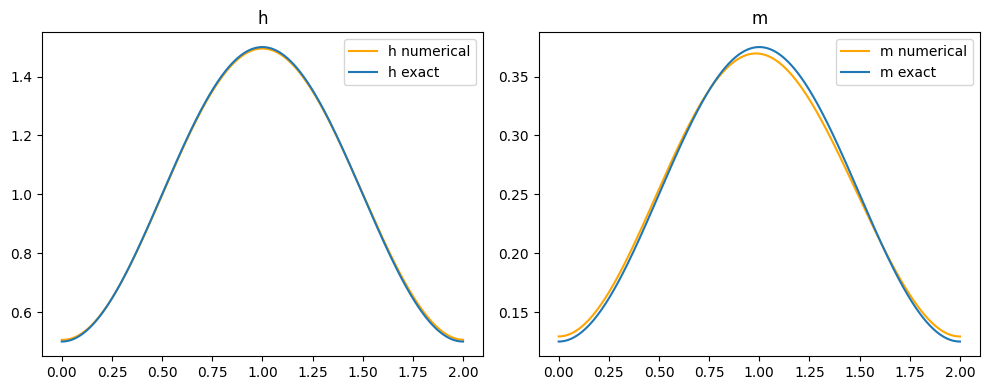

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

#fig.suptitle(f'Plots of the numerical solution against the analytical solution for N = {int(N/2)} at T = {final_time}')

x = Problem.x
h_sol = Problem.q[0]
m_sol = Problem.q[1]

# Plot data on the first subplot
axs[0].plot(x, h_sol, label='h numerical' , color = "orange")
axs[0].plot(x, h_exact(x , final_time), label='h exact')
axs[0].set_title('h')
axs[0].legend()

# Plot data on the second subplot
axs[1].plot(x, m_sol, label='m numerical', color='orange')
axs[1].plot(x, m_exact(x , final_time), label='m exact')
axs[1].set_title('m')
axs[1].legend()

# Adjust layout to prevent clipping of titles
plt.tight_layout()

#tikz.save('plots/1bcomparison.tex', figure=fig, standalone=True, encoding='utf-8')
# Show the plot
plt.show()

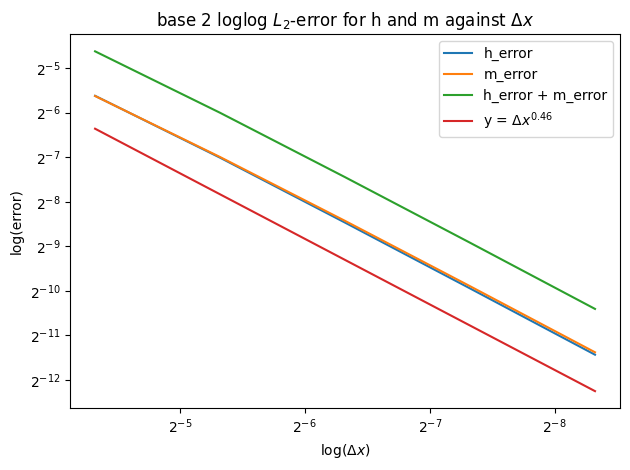

In [8]:
plt.plot(dxs , h_error, label = "h_error")
plt.plot(dxs , m_error, label = "m_error")
plt.plot(dxs , h_error + m_error, label = "h_error + m_error")
plt.plot(dxs, dxs**(1+0.4718861316088625), label = 'y = $\Delta x ^{1.46}$')
#plt.plot(dxs , Frobenius , label = "Frobenius")
plt.xlabel('log($\Delta x$)')
plt.ylabel('log(error)')
plt.xscale("log", base=2)
plt.yscale("log", base=2)
plt.gca().invert_xaxis()
plt.legend()


plt.title(f'base 2 loglog $L_2$-error for h and m against $\Delta x$')
plt.tight_layout()
#plt.savefig("plots/1berror.png")

# Show the plots
plt.show()

In [9]:
logError = np.log(h_error+m_error)
logDx = np.log(dxs)

# polynomial decay of error
np.mean((logError[1:]-logError[0:-1]) / (logDx[1:]-logDx[0:-1]))

1.4447116494974384

In [10]:
# Create a matrix with the independent variable (x)
A = np.vstack([logDx, np.ones(len(logDx))]).T

# Use numpy's least squares function to find the coefficients (m, c)
m, c = np.linalg.lstsq(A, logError, rcond=None)[0]
print(m,c)

1.447293289627145 1.157153093860861


# Problem 2

In [18]:
# Define Problem
final_time = 0.5
N = 40
bc = "P"
iterations = 4

#Calculate solution for very fine mesh:
N_ref = N * 2**(iterations)
print(f"Calculating reference solution with N={N_ref}")
Ref = SHE(T = final_time , N = N_ref)
Ref.set_BC("P")
Ref.IV(h0_B , m0_B)
Ref.set_Source(False)
x_ref = Ref.x
Ref.Solve()

h_ref = Ref.q[0]
m_ref = Ref.q[1]

Problem , h_error, m_error, dxs = Convergence_analysis(final_time , N , iterations , bc , h0_B, m0_B, h_ref, m_ref, exact=False, Source = False)

Calculating reference solution with N=640
Doing test with N=40
(41,)
Doing test with N=80
(81,)
Doing test with N=160
(161,)
Doing test with N=320
(321,)


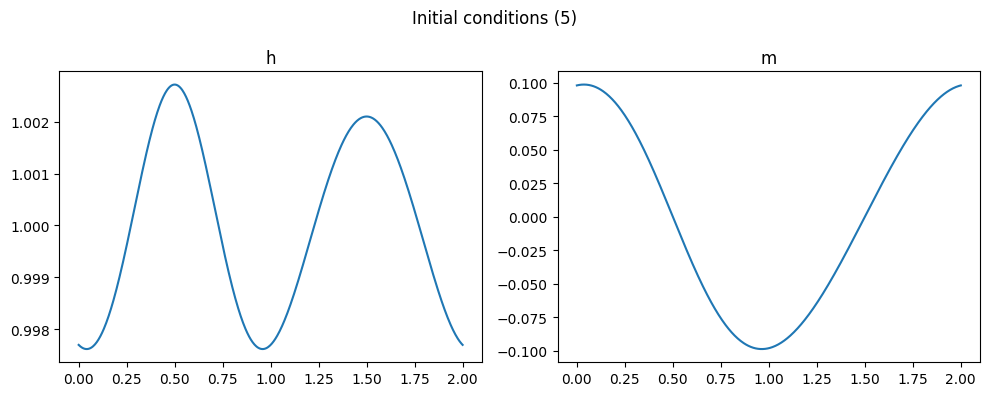

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

fig.suptitle("Initial conditions (5)")

# Plot data on the first subplot
axs[0].plot(x_ref, h_ref, label='h_exact')
axs[0].set_title('h')

# Plot data on the second subplot
axs[1].plot(x_ref, m_ref, label='m_exact')
axs[1].set_title('m')

# Adjust layout to prevent clipping of titles
plt.tight_layout()

# Show the plot
plt.show()

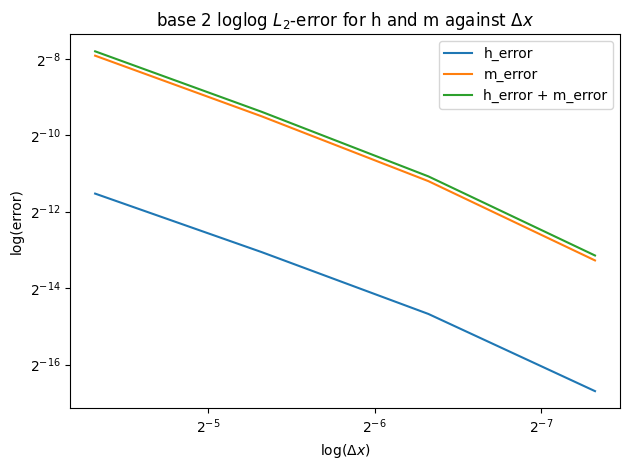

In [21]:
plt.plot(dxs , h_error, label = "h_error")
plt.plot(dxs , m_error, label = "m_error")
plt.plot(dxs , h_error + m_error, label = "h_error + m_error")
#plt.plot(dxs, dxs**(1+0.4718861316088625), label = 'y = $\Delta x ^{0.46}$')
#plt.plot(dxs , Frobenius , label = "Frobenius")
plt.xlabel('log($\Delta x$)')
plt.ylabel('log(error)')
plt.xscale("log", base=2)
plt.yscale("log", base=2)
plt.gca().invert_xaxis()
plt.legend()


plt.title(f'base 2 loglog $L_2$-error for h and m against $\Delta x$')
plt.tight_layout()
#plt.savefig("plots/1berror.png")

# Show the plots
plt.show()

### Case C

In [23]:
# Define Problem
final_time = 0.5
N = 40
bc = "P"
iterations = 4

#Calculate solution for very fine mesh:
N_ref = N * 2**(iterations)
print(f"Calculating reference solution with N={N_ref}")
Ref = SHE(T = final_time , N = N_ref)
Ref.set_BC("P")
Ref.IV(h0_C , m0_C)
Ref.set_Source(False)
x_ref = Ref.x
Ref.Solve()

h_ref = Ref.q[0]
m_ref = Ref.q[1]

Problem , h_error, m_error, dxs = Convergence_analysis(final_time , N , iterations , bc , h0_C, m0_C, h_ref, m_ref, exact=False, Source = False)

Calculating reference solution with N=640
Doing test with N=40
(41,)
Doing test with N=80
(81,)
Doing test with N=160
(161,)
Doing test with N=320
(321,)


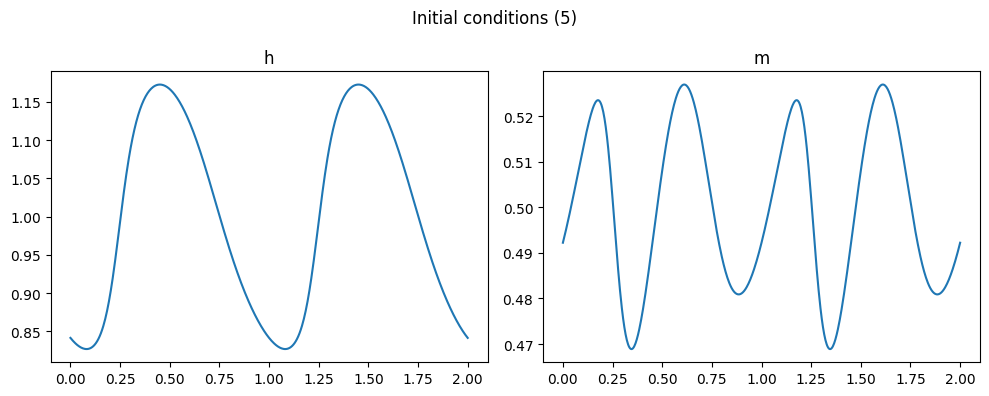

In [24]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

fig.suptitle("Initial conditions (5)")

# Plot data on the first subplot
axs[0].plot(x_ref, h_ref, label='h_exact')
axs[0].set_title('h')

# Plot data on the second subplot
axs[1].plot(x_ref, m_ref, label='m_exact')
axs[1].set_title('m')

# Adjust layout to prevent clipping of titles
plt.tight_layout()

# Show the plot
plt.show()

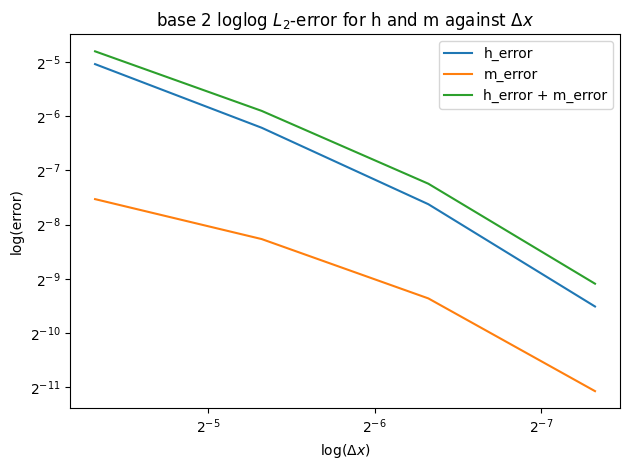

In [25]:
plt.plot(dxs , h_error, label = "h_error")
plt.plot(dxs , m_error, label = "m_error")
plt.plot(dxs , h_error + m_error, label = "h_error + m_error")
#plt.plot(dxs, dxs**(1+0.4718861316088625), label = 'y = $\Delta x ^{0.46}$')
#plt.plot(dxs , Frobenius , label = "Frobenius")
plt.xlabel('log($\Delta x$)')
plt.ylabel('log(error)')
plt.xscale("log", base=2)
plt.yscale("log", base=2)
plt.gca().invert_xaxis()
plt.legend()


plt.title(f'base 2 loglog $L_2$-error for h and m against $\Delta x$')
plt.tight_layout()
#plt.savefig("plots/1berror.png")

# Show the plots
plt.show()

# Problem 3.a

In [46]:
### Define Problem
time = 0.5
Problem = SHE(T =time, N=640)

Problem.set_BC("O")

Problem.set_Source(False)

Problem.IV(h0_D , m0_D)

Problem.Solve()

x_ex = Problem.x.copy()
h_ex = Problem.q[0].copy()
m_ex = Problem.q[1].copy()

# Problem 3.b

Doing test with N=100
Doing test with N=350


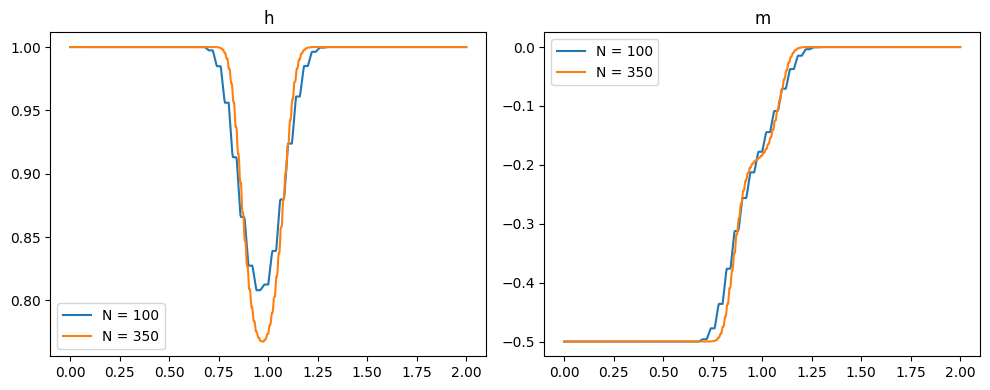

In [47]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
Problem.T = 0.1
step = 250
num_steps = 1
Problem.update_N(100)
error = np.array([])

original_N = Problem.N
for n in np.linspace(original_N, original_N+num_steps*step, num_steps+1, dtype=int):
    print(f"Doing test with N={n}")
    Problem.update_N(n)

    Problem.IV(h0_D , m0_D)

    Problem.Solve()

    axs[0].plot(x, np.interp(x_ex, Problem.x, Problem.q[0]), label=f'N = {n}')
    axs[1].plot(x, np.interp(x_ex, Problem.x, Problem.q[1]), label=f'N = {n}')


axs[0].set_title('h')
axs[0].legend()

axs[1].set_title('m')
axs[1].legend()

# Adjust layout to prevent clipping of titles
plt.tight_layout()

# Show the plot
plt.show()

# Problem 3.c

Doing test with N=100
Doing test with N=350


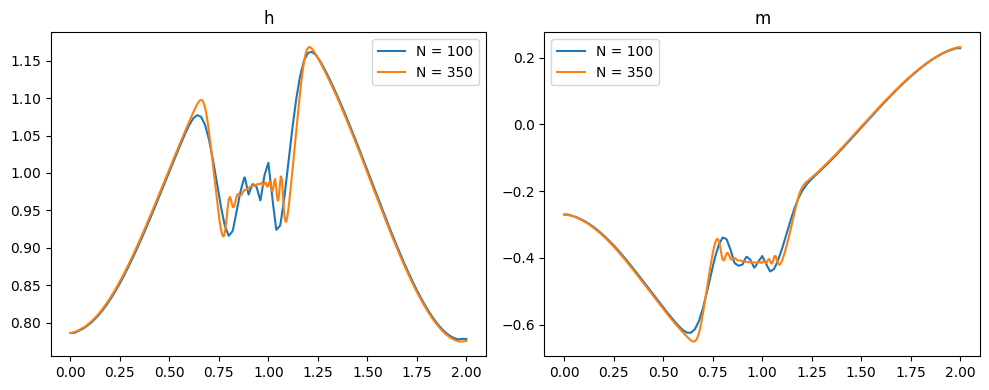

In [51]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

step = 250
num_steps = 1
Problem = SHE(T =time, N=640, flux = "LW")
Problem.set_BC("O")
#Problem.IV()
Problem.T=0.2
Problem.update_N(100)
error = np.array([])

original_N = Problem.N
for n in np.linspace(original_N, original_N+num_steps*step, num_steps+1, dtype=int):
    print(f"Doing test with N={n}")
    Problem.update_N(n)

    Problem.IV(h0_D , m0_D)

    Problem.Solve()

    axs[0].plot(x, np.interp(x_ex, Problem.x, Problem.q[0]), label=f'N = {n}')
    axs[1].plot(x, np.interp(x_ex, Problem.x, Problem.q[1]), label=f'N = {n}')

axs[0].set_title('h')
axs[0].legend()

axs[1].set_title('m')
axs[1].legend()

# Adjust layout to prevent clipping of titles
plt.tight_layout()

# Show the plot
plt.show()